# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from pprint import pprint as pp

import re
import spacy
import en_core_web_sm
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

from gensim.models import TfidfModel
import gensim.corpora as corpora

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
mallet_path = '/home/hungnguyen/mallet-2.0.8/bin/mallet'

# Import DataAnalyst.csv, Select Relevant Columns and Renaming

In [2]:
df = pd.read_csv('../data/DataAnalyst.csv')
df = df[['Job Title', 'Job Description','Size','Salary Estimate','Sector']]
df.columns = ['title','description','size','salary','sector']

# Clean Job Description

In [3]:
df['description'] = df['description'].str.replace(r'\n',' ').str.replace('  ',' ')

# Extract selected skills

In [4]:
def get_tech(sents):
    string = re.findall(r'\b\W?(SQL|Python|Power Bi|Tableau|R|Azure|Looker|Periscope|Alteryx|Java|Oracle|Hadoop)\W?\b',sents,re.I)
    string = [x.title() for x in string]
    string = list(set(string))
    string = ', '.join(string)
    return(string)
    
df['skills'] = df['description'].apply(get_tech)

# Put Selected Skills into dummy variables

In [5]:
tech_skills = ['Sql','Python','Power Bi','Tableau','R','Azure', 'Looker', 'Periscope', 'Alteryx', 'Java', 'Oracle', 'Hadoop']

for ts in tech_skills:
    df[ts] = df['skills'].apply(lambda x: 1 if ts in x else 0)
df.drop('skills',axis=1,inplace=True)

# Visualizing Skills Required Across 2253 Job Posts on Glassdoor

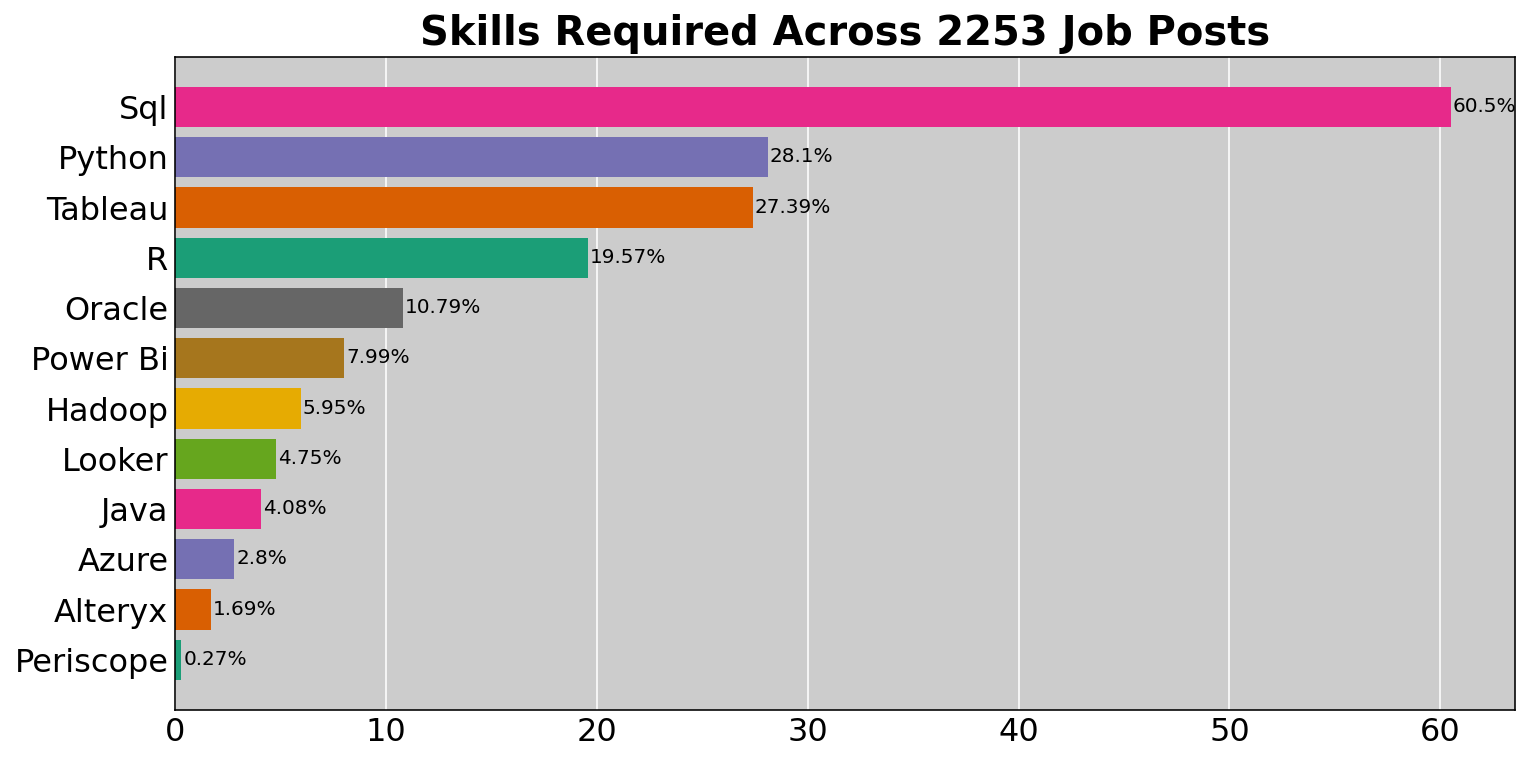

In [6]:
df_tech = df.loc[:,'Sql':'Hadoop'].sum(axis=0).reset_index().sort_values(0)
df_tech.columns = ['Skill','Count']
df_tech['Percentage'] =np.round(100*df_tech['Count']/df.shape[0],2)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6), dpi=144)
colors = plt.cm.Dark2(range(8))
y = df_tech.Skill
width = df_tech.Percentage

ax.barh(y=y, width=width, color=colors)
ax.set_facecolor('.8')
ax.tick_params(labelsize=16, length=0)
ax.grid(True,axis='x',color='white')
ax.set_axisbelow(True)
ax.set_title('Skills Required Across {} Job Posts'.format(df.shape[0]),fontsize=20,fontweight=600)
for idx, label in enumerate(width):
    ax.text(label+0.1,idx-0.1,str(label)+'%')

# Clean Salary column and Calculate its Average value

In [7]:
def clean_salary(string):
    if string =='-1':
        average = np.nan
    else:
        string_list = re.findall('[\d]+',string)
        average = (int(string_list[0]) + int(string_list[1]))/2
    return average
    
warnings.filterwarnings('ignore')
df['salary'] = df['salary'].apply(clean_salary)

<>:5: DeprecationWarning: invalid escape sequence \d
<>:5: DeprecationWarning: invalid escape sequence \d
<>:5: DeprecationWarning: invalid escape sequence \d
<ipython-input-7-bea21acc8e62>:5: DeprecationWarning: invalid escape sequence \d
  string_list = re.findall('[\d]+',string)


# Visualizing Average Salary Across Sectors

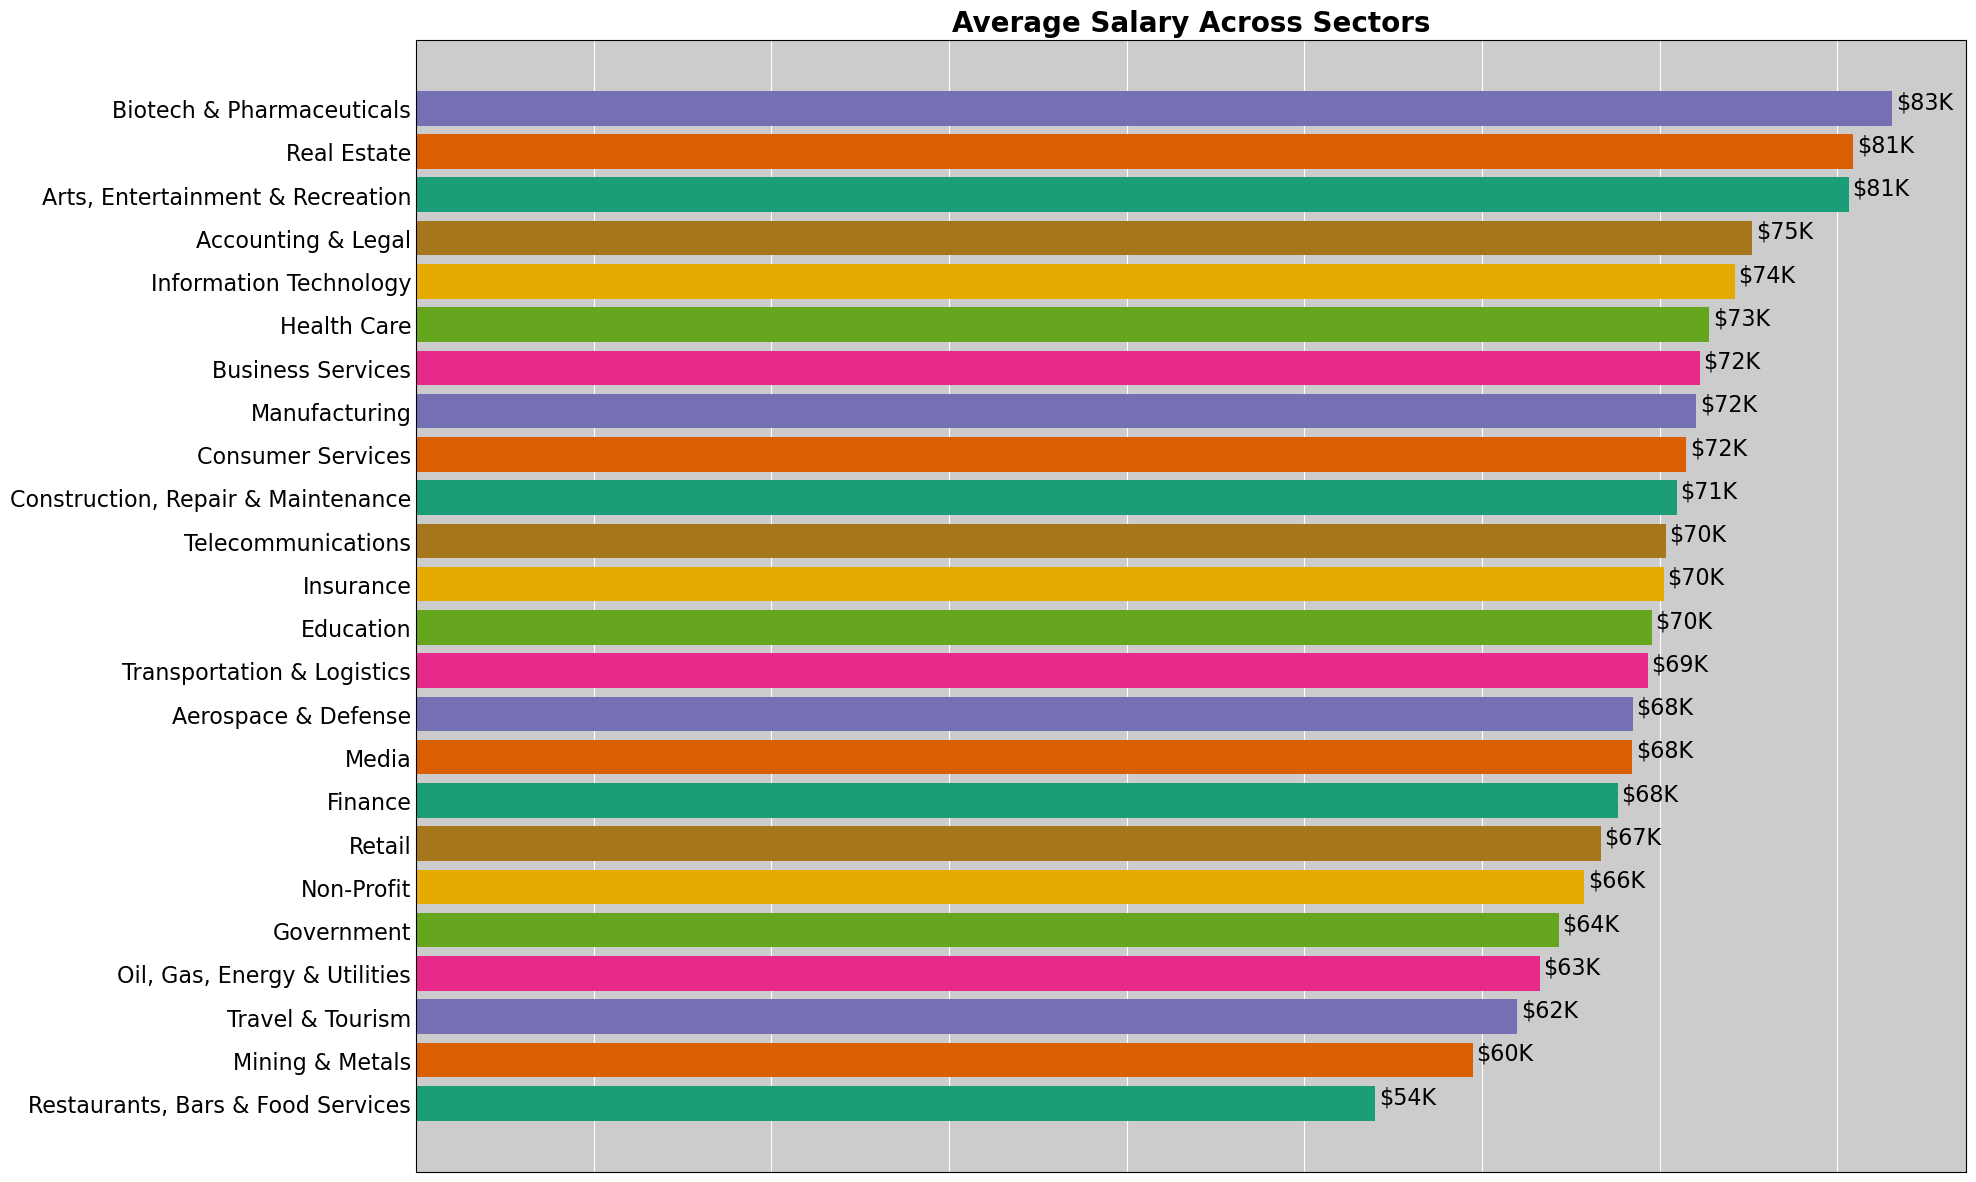

In [8]:
df_sectors = df.groupby('sector')['salary'].agg('mean').iloc[1:].reset_index().sort_values('salary',ascending=True)
colors = plt.cm.Dark2(range(7))
y = df_sectors.sector
width = df_sectors['salary']

fig, ax = plt.subplots(figsize=(20, 15), dpi=100)
ax.barh(y=y, width=width, color=colors)
ax.set_facecolor('.8')
ax.tick_params(labelsize=16, length=0)
ax.set_xticklabels([])
ax.grid(True,axis='x',color='white')
ax.set_axisbelow(True)
ax.set_title('Average Salary Across Sectors',fontsize=20,fontweight=600)
for idx, label in enumerate(width):
    ax.text(label+0.2,idx,'$'+str(round(label))+'K',fontsize=16)

# --------------------------------------------------Topic Modelling------------------------------------------------------------

In [9]:
docs = [des.strip().lower() for des in df.description]
# hyphen to underscores
docs = [re.sub(r'\b-\b', '_', text) for text in docs]
# load language model
nlp = en_core_web_sm.load()

# expand on spaCy's stopwords
stopwords_list = ['data','require','requires','requirement','requirements', 
                  'include','perform','standard','standards','award', 
                  'hypothesis','free','eligibility','able','level', 
                  'location','consumer','year','years','want','job','jobs',
                  'interview','interviews','description','descriptions']
for stopword in stopwords_list:
    nlp.vocab[stopword].is_stop = True

# tokenize text
docs_tokens, tmp_tokens = [], []
for doc in docs:
    tmp_tokens = [token.lemma_ for token in nlp(doc)
                  if not token.is_stop
                  and not token.is_punct
                  and not token.like_num
                  and token.is_alpha]
    docs_tokens.append(tmp_tokens)
    tmp_tokens = []

# take into account bi- and tri-grams
# get rid of common terms
common_terms = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', u'be', u'to', u'this', u'who', u'in']
# find phrases
bigram = Phrases(docs_tokens,
                 min_count=10,
                 threshold=5,   # higher means fewer phrases
                 max_vocab_size=50000,
                 common_terms=common_terms)
trigram = Phrases(bigram[docs_tokens],
                  min_count=10,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=common_terms)
# choose tri-grams
docs_phrased = [trigram[bigram[line]] for line in docs_tokens]

In [10]:
# create gensim corpora dictionary
dict_docs = Dictionary(docs_phrased)
# convert document into the bag-of-words format
corpus = [dict_docs.doc2bow(doc) for doc in docs_phrased]   

# Remove unimportant words via tf-idf algorithm

In [11]:
# Remove words that have important TF-IDF value less than 0.02
tfidf = TfidfModel(corpus, id2word=dict_docs)
low_value = 0.02
words = []
words_missing_in_tfidf = []

for i in range(0,len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf 
    for item in drops:
        words.append(dict_docs[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

# Finding optimal number of topics via coherence values

In [12]:
# define function to explore a gamut of competing models
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute coherence scores for various number of topics

    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus     : Gensim corpus
    texts      : List of input texts
    limit      : Max number of topics
    start      : Min number of topics
    step       : Searching step

    Returns:
    --------
    model_list       : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model
                       with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 id2word=dictionary,
                                                 random_seed=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        corpus=corpus,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Run from 1 to 10 topics to find the highest coherence values
limit, start, step = 10, 1, 1
model_list, coher_vals = compute_coherence_values(dictionary=dict_docs,
                                                  corpus=corpus,
                                                  texts=docs_phrased,
                                                  start=start,
                                                  limit=limit,
                                                  step=step)

In [13]:
# optimal number of topics
optimal_number = [idx+1 for idx, x in enumerate(coher_vals) if x == max(coher_vals)][0]
optimal_number

9

# Building a model with num_topics = 9

In [14]:
# model estimation
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path,
                                              corpus=corpus,
                                              num_topics=optimal_number,
                                              id2word=dict_docs,
                                              random_seed=123)

# Building a dataframe that contains significant words based on each of the 9 topics

In [15]:
n_topics = optimal_number
lda_mallet_g = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)
# get top 10 terms per topic
top_terms_line = lda_mallet_g.show_topics(num_topics=n_topics, 
                                          num_words=10)

# rearrange data on top 10 terms per topic
top_terms_m = []
for i in top_terms_line:
    topic_num = i[0]
    prob_terms = i[1].split('+')
    for term_sort, term in enumerate(prob_terms):
        weight = float(term.split('*')[0])
        term = term.split('*')[1].strip('"| ')
        top_terms_m.append([topic_num, term_sort, weight, term])

df_term = pd.DataFrame(top_terms_m)

# rename columns
old_names = [0, 1, 2, 3]
new_names = ['topic_n', 'term_sort', 'weight', 'term']
cols = dict(zip(old_names, new_names))
df_term.rename(columns=cols, inplace=True)

df_term.set_index(['term_sort', 'topic_n'], inplace=True)
df_term = df_term.unstack()

# sideways table
df_h = pd.DataFrame()

for i in range(n_topics):
    terms = df_term['term'][i]
    weights = df_term['weight'][i]
    weights = pd.Series(['( %s )' % j for j in weights])
    df_h = pd.concat([df_h, terms, weights], axis=1)
df_h = df_h.T

In [16]:
# renaming df_h dataframe
topics_name = ['Topic_'+str(i) for i in range(1,10)]
probs_name = ['Probability_'+str(i) for i in range(1,10)]
idx_name = []
for i in range(len(topics_name)):
    idx_name.append(topics_name[i])
    idx_name.append(probs_name[i])
df_h.index = idx_name
df_h

,0,1,2,3,4,5,6,7,8,9
Topic_1,business,solution,development,technical,team,technology,design,project,test,application
Probability_1,( 0.059 ),( 0.033 ),( 0.025 ),( 0.023 ),( 0.02 ),( 0.018 ),( 0.017 ),( 0.017 ),( 0.013 ),( 0.013 )
Topic_2,information,position,application,program,report,support,employee,system,require,service
Probability_2,( 0.022 ),( 0.021 ),( 0.014 ),( 0.011 ),( 0.009 ),( 0.009 ),( 0.009 ),( 0.009 ),( 0.008 ),( 0.008 )
Topic_3,research,health,healthcare,program,center,clinical,care,statistical,analysis,science
Probability_3,( 0.027 ),( 0.02 ),( 0.016 ),( 0.011 ),( 0.01 ),( 0.01 ),( 0.01 ),( 0.01 ),( 0.008 ),( 0.008 )
Topic_4,ability,knowledge,skill,strong,database,require,sql,analyst,query,excellent
Probability_4,( 0.053 ),( 0.037 ),( 0.032 ),( 0.031 ),( 0.027 ),( 0.024 ),( 0.021 ),( 0.016 ),( 0.012 ),( 0.011 )
Topic_5,company,employee,opportunity,service,disability,status,network,benefit,employment,technology
Probability_5,( 0.024 ),( 0.012 ),( 0.011 ),( 0.01 ),( 0.009 ),( 0.008 ),( 0.008 ),( 0.008 ),( 0.007 ),( 0.007 )


# Matching the topics with the document 

In [17]:
# get transformed corpus as per the LDA model
transf_corpus = lda_mallet_g.get_document_topics(corpus,
                                                 minimum_probability=0)

# rearrange data on document-topic pairs probabilities
doc_topics_m = []
for id, doc in enumerate(transf_corpus):
    for topic in np.arange(0, n_topics, 1):
        topic_n = doc[topic][0]
        topic_prob = doc[topic][1] 
        doc_topics_m.append([id, topic, topic_prob])

df_doc = pd.DataFrame(doc_topics_m)

# rename columns
old_names = [0, 1, 2]
new_names = ['doc_id', 'topic_n', 'prob']
cols = dict(zip(old_names, new_names))
df_doc.rename(columns=cols, inplace=True)

# dominant topic
gr = df_doc.groupby('doc_id')
df_doc.loc[:, 'max'] = gr['prob'].transform(np.max)
# use binary 0/1 to find the topic with the highest probability
df_doc.loc[:, 'first_topic'] = 0
df_doc.loc[df_doc['prob'] == df_doc['max'], 'first_topic'] = 1

first_topic = df_doc.loc[df_doc['first_topic'] == 1]

# arrange data as contingency table
df_doc = df_doc.pivot_table(index='doc_id', 
                            columns='topic_n', 
                            values='prob', 
                            aggfunc=np.mean)
                            
df['topic'] = first_topic.reset_index(drop=True)['topic_n']

# Making a dataframe to help building a stacked bar chart visualization

In [18]:
# Only select 2 relevant columns
df_bar = df[['sector','topic']]


# Only select 4 relevant sectors due to lack of number of observations
df_bar = df_bar.loc[df_bar['sector'].isin(['Information Technology','Business Services','Finance','Health Care'])]

# Using groupby to find its count
df_barchart = df_bar.groupby(['topic','sector'])['sector'].count().unstack().fillna(0)

# Calculating the percentage 
for c in df_barchart.columns:
    df_barchart.loc[:,c] = round((df_barchart.loc[:,c]*100/df_barchart.loc[:,c].sum()),3)

# Renaming its column
df_barchart = df_barchart.T
df_barchart.columns = [i for i in range(1,10)]


 # Visualizing How Topics distributed across sectors

<Figure size 1080x720 with 0 Axes>

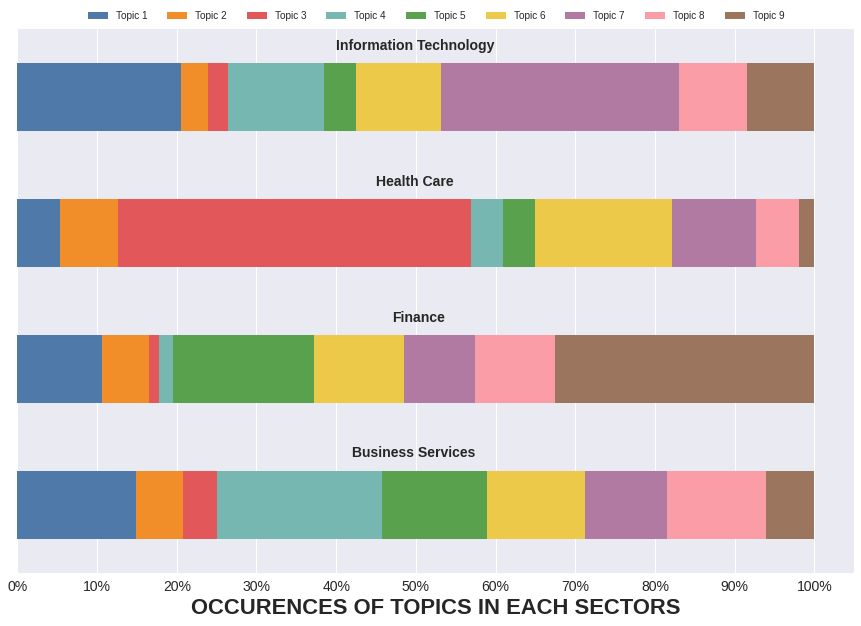

In [19]:
# Visualizing How Topics distributed across sectors
plt.style.use('seaborn')
plt.figure(figsize=(15,10))
df_barchart.plot(kind='barh',stacked=True,figsize=(15,10),color=['#4e79a8','#f28e2a','#e1575a','#76b7b2','#59a14d','#edc949','#b07aa2','#fa9da7','#9c755f','#bab0ac'])

plt.ylabel('',size=18,weight=550)
plt.xlabel('',size=22,weight=850)

plt.xlabel('OCCURENCES OF TOPICS IN EACH SECTORS')

plt.xticks(range(0,110,10),[str(x)+'%' for x in range(0,110,10)],size=14)
plt.yticks([])

plt.text(40,3.35,'Information Technology',size=14,weight=650)
plt.text(45,2.35,'Health Care',size=14,weight=650)
plt.text(47,1.35,'Finance',size=14,weight=650)
plt.text(42,0.35,'Business Services',size=14,weight=650)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=10, fancybox=False, shadow=True,labels=['Topic '+str(x) for x in range(1,10)])

plt.savefig('barchart.png')
plt.show()


# Comment

### General Knowledge
- Aside from MicroSoft Tools, SQL is a must have to get an data analyst role
- In terms of salary, Biotech - Real Estate - Accounting/Legal pay the highest

### Topic Modelling
- I.T Sector focus more on topic 1  meaning finding solution and developing are the required tasks. Additionally, terms like healthcare, company, employee appear less often, indicating that there are not many external benefits working with I.T Sector
 <br> <br>
- Health Care Sector focus more on topic 3 meaning Researching and Analysing are the main required tasks while having health care benefits are a norm. Additionally, terms like Client, Sale, Financial appear less often, indicating that Health Care Sector does not prioritize financial aspect.
 <br> <br>
- Finance Sector focus more on topic 9  which means interaction with clients, working with strategy to calculate risks is a norm in Financial Sector. Additionally, terms relating to SQL, HealthCare are less important indicating working within Finacial Sector are less likely to work with SQL, have healthcare benefits like others